# Calculate Nuclear Density

In this notebook we will use the nuclear masks and the cell masks to calculate the nuclear density.

In [1]:
from glob import glob 
from skimage.measure import regionprops_table
from skimage import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

## Prepare path to files 

In [2]:
path_1 = r'..\A5\training\240306\Cell_Masks\*.tif'
path_1_nuclei = r'..\A5\training\240306\Masks\*.tif'
path_1_skeleton = r'..\A5\training\240306\Skeleton\*.tif'

path_2 = r'..\A5\240321\Cell_Masks\*.tif'
path_2_nuclei = r'..\A5\240321\StarDistOutput_Corrected\*.tif'
path_2_skeleton = r'..\A5\240321\Skeleton\*.tif'

path_3 = r'..\A5\240325\Cell_Masks\*.tif'
path_3_nuclei = r'..\A5\240325\StarDistOutput_corrected\*.tif'
path_3_skeleton = r'..\A5\240325\Skeleton\*.tif'

In [3]:
rep1_files = zip(sorted(glob(path_1)),sorted(glob(path_1_nuclei)),sorted(glob(path_1_skeleton)))
rep2_files = zip(sorted(glob(path_2)),sorted(glob(path_2_nuclei)),sorted(glob(path_2_skeleton)))
rep3_filesb = zip(sorted(glob(path_3)),sorted(glob(path_3_nuclei)),sorted(glob(path_3_skeleton)))

***

## Define function for counting nuclei per cell mask

In [5]:
def count_nuclei_per_area(cell_mask, nuclei_mask, skeleton_mask):
    """Count the number of nuclei within each cell mask ID"""
    nuclei_df = pd.DataFrame(regionprops_table(nuclei_mask,properties=['area','centroid']))
    
    cell_df = pd.DataFrame(regionprops_table(cell_mask,properties=['area','axis_major_length','axis_minor_length', 'label']))
    
    counts = {}
    for label in np.unique(cell_df.label.values):
        counts[label] = 0 
    
    for y,x in nuclei_df[['centroid-1','centroid-2']].values:
        y,x=int(y),int(x)
        
        if cell_mask[y,x] > 0:
            counts[cell_mask[y,x]] += 1
            
    cell_df['Counts'] = cell_df['label'].map(counts)
    cell_df['path'] = cell_path

    cell_df['length (pixels)'] = len(skeleton_mask[skeleton_mask > 0])
    
    return cell_df

***

## Count for Rep1

In [6]:
cell_dfs = []
for cell_path,nuclei_path, skeleton_path in rep1_files:

    #convert branch mask to binary mask
    cell_mask = io.imread(cell_path)
    cell_binary =cell_mask > 0
    cell_mask = cell_binary.astype(int)

    #load nuclei mask and skeleton
    nuclei_mask = io.imread(nuclei_path)
    skeleton_mask = io.imread(skeleton_path)
        
    cell_df = count_nuclei_per_area(cell_mask,nuclei_mask, skeleton_mask)
    cell_dfs.append(cell_df)

rep1_frame =pd.concat(cell_dfs)
rep1_frame['Rep'] = 1

## Count for Rep2 

In [8]:
cell_dfs = []
for cell_path,nuclei_path, skeleton_path in rep2_files:

    #convert branch mask to binary mask
    cell_mask = io.imread(cell_path)
    cell_binary =cell_mask > 0
    cell_mask = cell_binary.astype(int)

    #load nuclei mask and skeleton
    nuclei_mask = io.imread(nuclei_path)
    skeleton_mask = io.imread(skeleton_path)
        
    cell_df = count_nuclei_per_area(cell_mask,nuclei_mask, skeleton_mask)
    cell_dfs.append(cell_df)

rep2_frame =pd.concat(cell_dfs)
rep2_frame['Rep'] = 2

## Count for Rep3

In [9]:
cell_dfs = []
for cell_path,nuclei_path, skeleton_path in rep3_files:

    #convert branch mask to binary mask
    cell_mask = io.imread(cell_path)
    cell_binary =cell_mask > 0
    cell_mask = cell_binary.astype(int)

    #load nuclei mask and skeleton
    nuclei_mask = io.imread(nuclei_path)
    skeleton_mask = io.imread(skeleton_path)
        
    cell_df = count_nuclei_per_area(cell_mask,nuclei_mask, skeleton_mask)
    cell_dfs.append(cell_df)

rep3_frame =pd.concat(cell_dfs)
rep3_frame['Rep'] = 3

***

## Data wrangling 

In [10]:
df  = pd.concat([rep1_frame,rep2_frame,rep3_frame])
df.head(3)

,area,axis_major_length,axis_minor_length,label,Counts,path,length (pixels),Rep
0,345764.0,2497.321846,1433.422173,1,51,..\A5\training\240306\Cell_Masks\A5_Cellophane...,3930,1
0,720752.0,2720.953699,1675.480442,1,145,..\A5\training\240306\Cell_Masks\A5_Cellophane...,4311,1
0,902715.0,2934.163172,1348.916616,1,127,..\A5\240321\Cell_Masks\A5_DAPI_staining_00.tif,5469,2


In [11]:
df['area (uM)'] = df['area'] * (0.108**2)
df['nuclei per area (uM)']= ((df['Counts'] / df['area (uM)']))

In [12]:
df['length (uM)'] = df['length (pixels)'] * 0.108

In [13]:
df['nuclei per length (uM)']= ((df['Counts'] / df['length (uM)']))

In [12]:
# df.to_csv('df_nuclear_density.csv') 

***

## Plotting

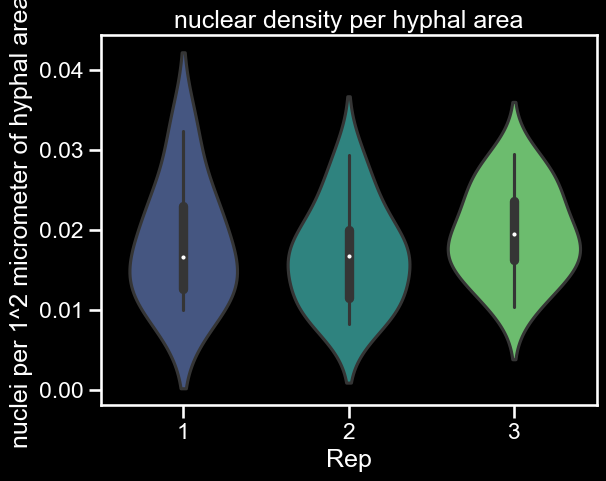

In [13]:
ax = sns.violinplot(data=df, y='nuclei per area (uM)', x='Rep', palette = 'viridis')
ax.set_ylabel('nuclei per 1^2 micrometer of hyphal area')
ax.set_title('nuclear density per hyphal area')

plt.savefig('violin_nuclei_per_area.png',dpi=600)

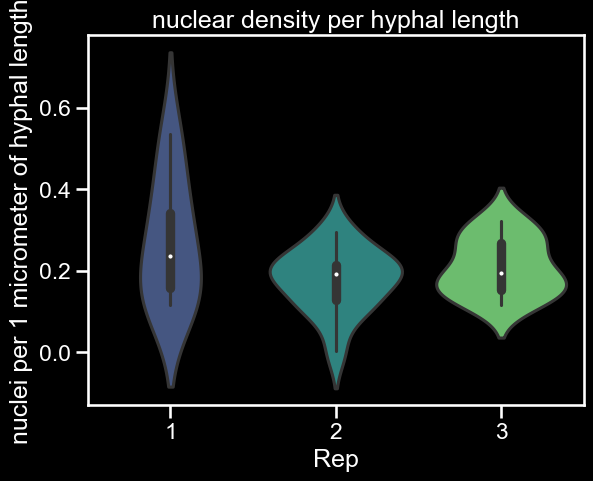

In [14]:
ax = sns.violinplot(data=df, y='nuclei per length (uM)', x='Rep', palette = 'viridis')
ax.set_ylabel('nuclei per 1 micrometer of hyphal length')
ax.set_title('nuclear density per hyphal length')
plt.savefig('violin_nuclei_per_length.png',dpi=600)

In [18]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

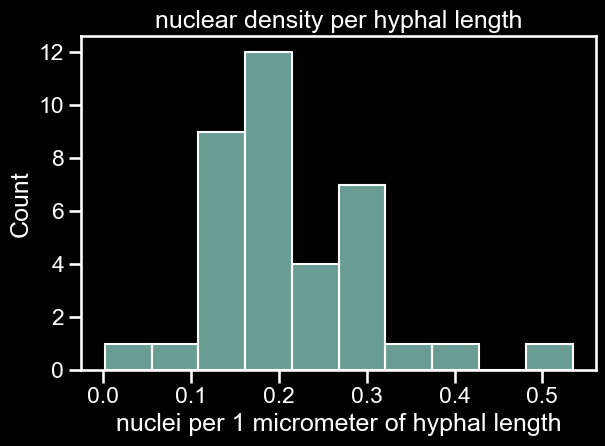

In [20]:
ax =sns.histplot(data=df, x='nuclei per length (uM)', bins=10)
ax.set_xlabel('nuclei per 1 micrometer of hyphal length')
ax.set_title('nuclear density per hyphal length')
plt.savefig('histogram_nuclei_per_length.png',dpi=600)

In [22]:
df['nuclei per length (uM)'].std()

0.09870678464681346

In [23]:
df['nuclei per length (uM)'].mean()

0.20970658132868808

In [24]:
df['nuclei per area (uM)'].std()

0.006219771914319127

In [25]:
df['nuclei per area (uM)'].mean()

0.01822175184221017